# Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning

## Case Study: Detecting Intertidal Reefs

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

## Part 5: Train a oyster reef masker using a custom learning rate scheduler

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)

Then we will construct, train and evaluate the model. In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors used a bigger, more sophisticated model for `instance segmentation`, that is, semantic segmentation that is aware of all the different `instances` of the class (i.e. each individual piece of reef). The model they use is called `Mask RCNN`, the implementation of which is [here](https://github.com/matterport/Mask_RCNN). That is a large and very complicated model that is hard to experiment with. The research behind the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134) is state-of-the-art.

Here, we use a simpler model with fewer parameters (namely, a residual UNet) and acheive acceptable results for a semantic segmentation (predicting the masks of where the reefs are, rather than by individual instances). The UNet is the same we used in a [previous set of tutorials](https://mardascience.gitlab.io/deep_learning_landscape_classification/#/) and is relatively simple to adapt and play with to demonstrate a few principles.

**In this tutorial, we'll adapt our training strategies in search of a more satisfactory result. This may or may not be directly transferable with the same fidelity to your own dataset, but this is a good trick to learn and understand that might help for your data modelling purposes. This time we use a cyclical learning rate scheduler**

According to [this](https://arxiv.org/abs/1506.01186) and [this](https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/), there are a few reasons why we would want to trial this strategy
* a low learning rate may not be sufficient to break out of the non-optimal areas of the loss landscape and descend into areas of the loss landscape with lower loss.
* our model and optimizer may be very sensitive to our initial learning rate choice


This is designed to demonstrate a problem-solving strategy, and also a principle that often applies to natural imagery:

> It's not just the model you choose, it's how you train it that counts




### Import libraries

In [0]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import json # for reading lable annotations in json format
import requests #for downloading files 
from PIL import Image, ImageFilter #for reading and filtering imagery
import skimage.draw #for making masks (raster label images) from label annotations
from skimage.transform import resize #for resizing imagery
from psutil import virtual_memory #for interrogating our filesystem and RAM specifications
from imageio import imwrite

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from random import shuffle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model

### Prepare the data

#### Download the  imagery


For the remainder of the tutorials, we'll be using this version of the data, consisting of imagery and image labels, with an augmented training set consisting of double the original number of imagery, half of which have been augmented with random flips, zoms and rotations

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
file_id = '19RgkzaD9w-rvAF9uBpqMONnwF0lJVPh3'
destination = 'train_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_images.tar.gz > tmp.txt

In [0]:
file_id = '1gjWGXO7mtBhJuSOqrG6B1inzLF8TfTSX'
destination = 'val_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_images.tar.gz > tmp.txt

In [0]:
file_id = '1x8HrgEStkBCdBmFNo1xa0x6LCVE2GE1g'
destination = 'train_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_labels.tar.gz > tmp.txt

In [0]:
file_id = '1v0kPgwZVQNrGAk0awJi31W83CYvHJbeX'
destination = 'val_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_labels.tar.gz > tmp.txt

In [0]:
root = './content/'

Check to see how many images we now have to work with

In [0]:
train_files = glob(root+"1kx1k_dataset/train_images/data/*.png")
val_files = glob(root+"1kx1k_dataset/val_images/data/*.png")

print("# train files: %i" % (len(train_files)))
print("# validation files: %i" % (len(val_files)))

# train files: 1054
# validation files: 130


### Setting up model training

#### Custom batch generator

We are going to feed images to the network in batches. The batch size (number of images and associated labels) will be ...

In [0]:
batch_size = 6

The next function is an image batch generator. A `generator` is a special type of python function that `yields` a set of data. In our case, it will yield a set of `batch_size` images and labels drawn randomly from the entire set of `files` provided

It opens the file, reads it into a numpy array with correct dimensions checked, and then does the same for the label image. It scales the image by dividing by 255, do turn the 8-bit data scaled between 0 and 255 to data scaled between 0 and 1. The labels are flattened from 3D (RGB) to 2D (greyscale integers)

In [0]:
def image_batch_generator(files, sz, batch_size = 4):

  while True: # this is here because it will be called repeatedly by the training function

    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []

    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images
        raw = Image.open(f)
        raw = raw.resize(sz)
        raw = raw.filter(ImageFilter.UnsharpMask(radius=20, percent=100))
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        #get the image dimensions, find the min dimension, then square the image off
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:]

        raw[np.isnan(raw)] = 1e-5
        raw[np.isinf(raw)] = 1e-5

        batch_x.append(raw)

        #get the masks.
        maskfile = f.replace('_images','_labels').replace('.png','.jpg')
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        try:
           mask = np.max(np.array(mask.resize(sz)),axis=2)
        except:
           mask = np.array(mask.resize(sz))

        # water pixels are always greater than 170
        mask = (mask>170).astype('int') ##170 = (2/3)*255

        mask = mask[:n,:n]

        mask[np.isnan(mask)] = 1e-5
        mask[np.isinf(mask)] = 1e-5
        batch_y.append(mask)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x) #/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,1) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

We will specify input imagery of size `(512, 512, 3)`

In [0]:
sz = (512, 512)

#### Build the model

In [0]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
	

This is a class imbalanced problem, with many more `non-reef` pixels compared to `reef` pixels (the target class)

So, we will use (Sorensen-)Dice loss instead of the more common IoU score (Jaccard Index) which is more suitable for class balanced problems

In [0]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

Next, we make and compile our model

As we saw in lesson 1, model compilation is a necessary step, involving specifiying the 'optimizer' (we will use `rmsprop` but `adam` is also a good one to use, in my experience). The loss function is the Dice loss, and the metric we want to keep track of in the dice coefficient

In [0]:
model = res_unet(sz+(3,), batch_size)
model.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])

Let's take a look at how many parameters we have to optimize

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 6)  168         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 6)  24          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 6)  24          input_1[0][0]                    
______________________________________________________________________________________________

We have over 600,000 trainable parameters. This is a lot, for any model, but tiny compared to the number of parameters in some deep learning models, with up to hundreds of millions of trainable parameters

### Train the model with a custom "learning rate scheduler"

In [0]:
callbacks = tf.keras.callbacks
backend = tf.keras.backend


class PlotLearning(callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))

        #choose a random test image and preprocess
        f = np.random.choice(val_files)

        raw = np.array(Image.open(f).resize(sz))

        #predict the mask
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))

        #mask post-processing
        msk  = (pred>170).astype('int') 

        msk = np.stack((msk,)*3, axis=-1)

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()
        #plt.savefig(str(self.i)+'.png', dpi=100, bbox_inches='tight')

In Part 3 we used callback functions that adaptively change the pace of training (using an adaptive learning rate), called ["reduce loss on plateau"](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)

This time we'll control precisely the learning rate scheduler to invoke a function that describes the learning rate as a function of training epoch

To do so requires a new class that will feed the model the correct learning rate based on the epoch it is current training on



In [0]:
class LearningRateScheduler(callbacks.Callback):
    def __init__(self,
                 schedule,
                 learning_rate=None,
                 steps_per_epoch=None,
                 verbose=0):
        super(LearningRateScheduler, self).__init__()
        self.learning_rate = learning_rate
        self.schedule = schedule
        self.verbose = verbose
        self.warmup_epochs = 0 
        self.warmup_steps = 0 
        self.global_batch = 0

    def on_train_batch_begin(self, batch, logs=None):
        self.global_batch += 1
        if self.global_batch < self.warmup_steps:
            if not hasattr(self.model.optimizer, 'lr'):
                raise ValueError('Optimizer must have a "lr" attribute.')
            lr = self.learning_rate * self.global_batch / self.warmup_steps
            backend.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %05d: LearningRateScheduler warming up learning '
                      'rate to %s.' % (self.global_batch, lr))

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(backend.get_value(self.model.optimizer.lr))

        if epoch >= self.warmup_epochs:
            try:  # new API
                lr = self.schedule(epoch - self.warmup_epochs, lr)
            except TypeError:  # old API
                lr = self.schedule(epoch - self.warmup_epochs)
            if not isinstance(lr, (float, np.float32, np.float64)):
                raise ValueError('The output of the "schedule" function '
                                 'should be float.')
            backend.set_value(self.model.optimizer.lr, lr)

            if self.verbose > 0:
                print('\nEpoch %05d: LearningRateScheduler reducing learning '
                      'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)


This is our cosine function implementation for a 'cyclical' learning rate between two specified bounds, `min_lr` (minimum learning rate) and `max_lr` (maximum learning rate)

In [0]:
def cosine_ratedecay(max_epochs, max_lr, min_lr=1e-6): 
    """
    cosine scheduler.
    :param max_epochs: max epochs
    :param max_lr: max lr
    :param min_lr: min lr
    :return: current lr
    """
    max_epochs = max_epochs ##- 5 if warmup else max_epochs

    def ratedecay(epoch):
        lrate = min_lr + (max_lr - min_lr) * (
                1 + np.cos(np.pi*2 * epoch / max_epochs)) / 2

        return lrate

    return ratedecay

We now have two new hyperparameters we didn't have before

In [0]:
# maximum learning rate (lambda)
max_lr = 1e-4

max_epochs = 200

The "two bites at the cherry" learning rate scheduler. The intuition behind this is that the model searches progressively finer portions of the loss parameter space, up until about epoch 70, then the function increases again, using larger learning rates to explore other 'valleys' in the loss landscape. 

I informally call it the 'two bites at the cherry' function because it facilitates the following situation: the optimal low in the loss landscape was not effectively found by the first loop of progressively lower learning rates. Giving the model a 'second bite' allows it to find a new low by adjusting learning rates to be coarse, so it can hop to different areas of the loss landscape more effectively 

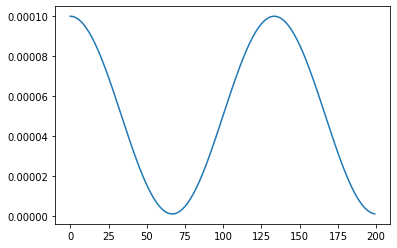

In [0]:
min_lr = 1e-6
def ratedecay(epoch):
    lrate = min_lr + (max_lr - min_lr) * (
            1 + np.cos(np.pi*3 * epoch / max_epochs)) / 2

    return lrate

plt.plot(ratedecay(np.arange(max_epochs)))    

Now we have defined all these hyperparameters (parameters that we chose, not automatically determined by the model), we can make a function that builds all the various callbacks together into a list, which can then be passed to the model training (`.fit()` function)

In [0]:
def build_callbacks(filepath, lr_ratedecay, lr, steps_per_epoch):

    # set checkpoint file
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min',
                                   save_weights_only = True)

    # learning rate scheduler setting
    learning_rate_scheduler = LearningRateScheduler(lr_ratedecay, lr, steps_per_epoch,
                                                verbose=1)

    callbacks = [model_checkpoint, learning_rate_scheduler, PlotLearning()]

    return callbacks

Next, set up a name for the `.h5` file that will be used to store model weights.

Finally, we train the model by calling the `.fit()` command and providing all the generators and hyperparameters defined in the callbacks

The number of training and validation steps is simply the number of respective files divided by the batch size

In [0]:
filepath = 'reefs_weights_uresnet'+str(batch_size)+'_'+str(max_epochs)+'epochs_cosine_lrscheduler.h5'

train_generator = image_batch_generator(train_files, sz, batch_size = batch_size)
val_generator  = image_batch_generator(val_files, sz, batch_size = batch_size)
train_steps = len(train_files) //batch_size
val_steps = len(val_files) //batch_size
steps_per_epoch = len(train_files) // batch_size

print(train_steps)
print(val_steps)
print(steps_per_epoch)

lr_ratedecay = cosine_ratedecay(max_epochs,max_lr)

175
21
175


If you'd rather not wait the 3-6 hours it might take to train the model you should leave the following cell uncommented 

In [0]:
file_id = '1LyjyOxuzYzmWrwh6kxPVDZZWEzZGehNq'
destination = 'weights_part5.h5'
download_file_from_google_drive(file_id, destination)
model.load_weights(destination)
max_epochs = 5 #just use 5 epochs

If you wish to train the model your own model, uncomment the cells below

In [0]:
# hist = model.fit(train_generator,
#                 epochs = max_epochs, steps_per_epoch = train_steps,
#                 validation_data = val_generator, validation_steps = val_steps,
#                 callbacks = build_callbacks(filepath,lr_ratedecay, max_lr, steps_per_epoch))

#### Plot the training history

In the above, we gave an output variable to the `.fit()` command. This contains the training histories. That is, losses and metrics as a function of epoch. You can access the variables in the dictionary like so

In [0]:
# hist.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])

Let's make a plot of the histories of both train and validation losses and dice coefficients, and also the history of the learning rate

In [0]:
# plt.figure(figsize=(20,10))
# plt.subplot(131)
# plt.plot(hist.history['dice_coef'], 'b', label='train Dice coefficient')
# plt.plot(hist.history['val_dice_coef'], 'k', label='validation Dice coefficient')
# plt.xlabel('Epoch number'); plt.ylabel('Dice coefficent')
# plt.legend()

# plt.subplot(132)
# plt.plot(hist.history['loss'], 'b', label='train loss')
# plt.plot(hist.history['val_loss'], 'k', label='validation loss')
# plt.xlabel('Epoch number'); plt.ylabel('Loss')
# plt.legend()

# plt.subplot(133)
# plt.plot(hist.history['lr'], 'g')
# plt.xlabel('Epoch number'); plt.ylabel('Learning rate')

### Test the model

Get the test set of files and untar like we did the other sets

In [0]:
file_id = '1lL6cbUNhwAQsDl4P4LIYiOMOwKxrhq-c'
destination = 'test_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf test_images.tar.gz > tmp.txt

In [0]:
file_id = '1GVZgjzuVatp-OjU5s5DJOgAteUvN1yDC'
destination = 'test_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf test_labels.tar.gz > tmp.txt

Get a test generator

In [0]:
test_files = glob(root+"1kx1k_dataset/test_images/*.png")

test_generator = image_batch_generator(test_files, sz, batch_size = batch_size)

print("# test files: %i" % (len(test_files)))

# test files: 163


Use the `.evaluate()` function of the model to get average Dice scores and losses for the test set



In [0]:
# some other training parameters
steps = len(test_files) // batch_size

# testing
scores = model.evaluate(test_generator, steps=steps) 

print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

27/27 [==============================] - 13s 496ms/step - loss: 0.1998 - dice_coef: 0.8002
loss=0.1998, Mean Dice=0.8002


In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors reeport a best precision of 0.771 and recall of 0.772. The Dice score is mathematically equivalent to the F1 score, the harmonic mean of precision and recall, or 77%

In Part 4, we acheived an average dice score of ~72% using a Dice loss function and adaptive learning rates that were contingent on validation loss

This time, with a cyclical learning rate, we acheive ~80% - approximately the same as the original paper (actually, a little higher!)